In [2]:
# Import our dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# libraries for text processing
import nltk
from nltk.stem.snowball import SnowballStemmer

# to display images
from skimage import io

# to save the required files
import pickle

Data Collection and Pre-Processing

In [4]:
#  Import and read the csv file
movies_df = pd.read_csv("..\csv\movies_data_cleaned.csv") # https://www.dropbox.com/s/q8yp2pkdsjazbph/movies_data.csv?dl=1
movies_df.head() 


id                              title   
0   76600           Avatar: The Way of Water  \
1  758323                The Pope's Exorcist   
2  594767           Shazam! Fury of the Gods   
3  640146  Ant-Man and the Wasp: Quantumania   
4  677179                          Creed III   

                             genres original_language   
0  Science Fiction-Adventure-Action                en  \
1           Horror-Mystery-Thriller                en   
2             Action-Comedy-Fantasy                en   
3  Action-Adventure-Science Fiction                en   
4                      Drama-Action                en   

                                            overview  popularity   
0  Set more than a decade after the events of the...    9366.788  \
1  Father Gabriele Amorth Chief Exorcist of the V...    5953.227   
2  Billy Batson and his foster siblings who trans...    5759.074   
3  Super-Hero partners Scott Lang and Hope van Dy...    4704.903   
4  After dominating the boxing world Adonis Creed...    3994.342   

                                production_companies release_date  runtime   
0      20th Century Studios-Lightstorm Entertainment   2022-12-14    192.0  \
1  Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...   2023-04-05    103.0   
2  New Line Cinema-The Safran Company-DC Films-Wa...   2023-03-15    130.0   
3             Marvel Studios-Kevin Feige Productions   2023-02-15    125.0   
4  Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...   2023-03-01    116.0   

   vote_average  vote_count   
0         7.751      6748.0  \
1         7.433       545.0   
2         6.840      1355.0   
3         6.448      1547.0   
4         7.262      1129.0   

                                             credits   
0  Sam Worthington-Zoe Saldaña-Sigourney Weaver-S...  \
1  Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...   
2  Zachary Levi-Asher Angel-Jack Dylan Grazer-Ada...   
3  Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...   
4  Michael B. Jordan-Tessa Thompson-Jonathan Majo...   

                                            keywords   
0  loss of loved one-dying and death-alien life-f...  \
1  spain-rome italy-vatican-pope-pig-possession-c...   
2  superhero-end of the world-super power-aftercr...   
3  hero-ant-sequel-superhero-based on comic-famil...   
4  philadelphia pennsylvania-husband wife relatio...   

                        poster_path   
0  /t6HIqrRAclMCA60NsSmeqe9RmNV.jpg  \
1  /9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg   
2  /2VK4d3mqqTc7LVZLnLPeRiPaJ71.jpg   
3  /ngl2FKBlU4fhbdsrtdom9LVLBXw.jpg   
4  /cvsXj3I9Q2iyyIo95AecSd1tad7.jpg   

                                     recommendations  
0  183392-111332-702432-505642-1064215-436270-874...  
1  713704-296271-502356-1076605-1084225-1008005-9...  
2  700391-994751-948713-640146-502356-938992-7660...  
3  965839-734048-267805-1035806-823999-842942-772...  
4  965839-267805-943822-842942-1035806-823999-107...

In [5]:
corr_matrix = movies_df[['id', 'popularity', 'runtime', 'vote_average', 'vote_count']].corr()

In [6]:
# Set the plot size, color, and font scale
sns.set(font_scale=1)
plt.figure(facecolor='gray', figsize=(10,8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

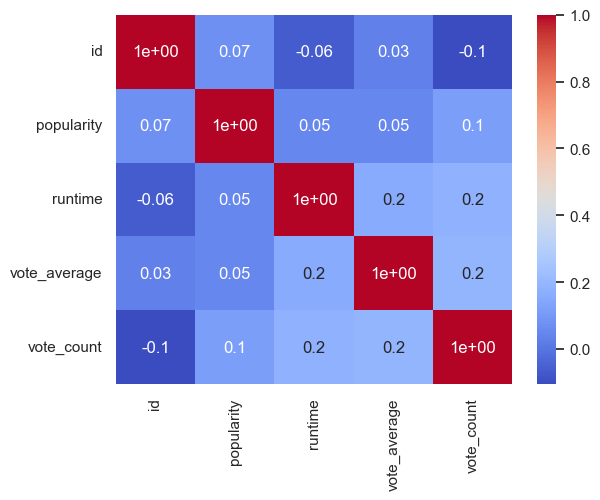

In [7]:
# Display the matrix
sns.heatmap(corr_matrix, annot=True, fmt='.0', cmap='coolwarm')
plt.show()

Feature Engeneering. Create popularity_score feature using vote_average and vote_count

In [8]:
def calculate_popularity(row):
    vote_count = row['vote_count']
    vote_average = row['vote_average']
    # Example formula: Popularity score = (vote_average * vote_count) / (vote_count + m)
    m = movies_df['vote_count'].quantile(0.90)  # Set the threshold based on your preference
    popularity_score = (vote_average * vote_count) / (vote_count + m)
    return popularity_score

In [9]:
# Apply the calculate_popularity function to create the new feature
movies_df['popularity_score'] = movies_df.apply(calculate_popularity, axis=1)


In [10]:
# Print the first few rows of the dataframe with the new feature
movies_df.head()

id                              title   
0   76600           Avatar: The Way of Water  \
1  758323                The Pope's Exorcist   
2  594767           Shazam! Fury of the Gods   
3  640146  Ant-Man and the Wasp: Quantumania   
4  677179                          Creed III   

                             genres original_language   
0  Science Fiction-Adventure-Action                en  \
1           Horror-Mystery-Thriller                en   
2             Action-Comedy-Fantasy                en   
3  Action-Adventure-Science Fiction                en   
4                      Drama-Action                en   

                                            overview  popularity   
0  Set more than a decade after the events of the...    9366.788  \
1  Father Gabriele Amorth Chief Exorcist of the V...    5953.227   
2  Billy Batson and his foster siblings who trans...    5759.074   
3  Super-Hero partners Scott Lang and Hope van Dy...    4704.903   
4  After dominating the boxing world Adonis Creed...    3994.342   

                                production_companies release_date  runtime   
0      20th Century Studios-Lightstorm Entertainment   2022-12-14    192.0  \
1  Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...   2023-04-05    103.0   
2  New Line Cinema-The Safran Company-DC Films-Wa...   2023-03-15    130.0   
3             Marvel Studios-Kevin Feige Productions   2023-02-15    125.0   
4  Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...   2023-03-01    116.0   

   vote_average  vote_count   
0         7.751      6748.0  \
1         7.433       545.0   
2         6.840      1355.0   
3         6.448      1547.0   
4         7.262      1129.0   

                                             credits   
0  Sam Worthington-Zoe Saldaña-Sigourney Weaver-S...  \
1  Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...   
2  Zachary Levi-Asher Angel-Jack Dylan Grazer-Ada...   
3  Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...   
4  Michael B. Jordan-Tessa Thompson-Jonathan Majo...   

                                            keywords   
0  loss of loved one-dying and death-alien life-f...  \
1  spain-rome italy-vatican-pope-pig-possession-c...   
2  superhero-end of the world-super power-aftercr...   
3  hero-ant-sequel-superhero-based on comic-famil...   
4  philadelphia pennsylvania-husband wife relatio...   

                        poster_path   
0  /t6HIqrRAclMCA60NsSmeqe9RmNV.jpg  \
1  /9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg   
2  /2VK4d3mqqTc7LVZLnLPeRiPaJ71.jpg   
3  /ngl2FKBlU4fhbdsrtdom9LVLBXw.jpg   
4  /cvsXj3I9Q2iyyIo95AecSd1tad7.jpg   

                                     recommendations  popularity_score  
0  183392-111332-702432-505642-1064215-436270-874...          6.134474  
1  713704-296271-502356-1076605-1084225-1008005-9...          1.743709  
2  700391-994751-948713-640146-502356-938992-7660...          2.958062  
3  965839-734048-267805-1035806-823999-842942-772...          2.999836  
4  965839-267805-943822-842942-1035806-823999-107...          2.820170

In [11]:
# Double checking for duplicates
movies_df[['title','release_date']].duplicated().sum()

0

In [12]:
movies_df.shape

(22400, 16)

In [13]:
# Genres, keywords and credits are seperated by '-', so replacing that with space and from credits only extracting first values words
movies_df['genres'] = movies_df['genres'].apply(lambda x: ' '.join(x.split('-')))
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: ' '.join(x.split('-')))
movies_df['credits'] = movies_df['credits'].apply(lambda x: ' '.join(x.replace(' ', '').split('-')[:5]))

In [14]:
# Creating tags
movies_df['tags'] = movies_df['overview'] +' '+ movies_df['genres'] +' '+ movies_df['keywords'] +' '+ movies_df['credits'] +' '+ movies_df['original_language']

In [15]:
movies_df['tags'][0]

'Set more than a decade after the events of the first film learn the story of the Sully family (Jake Neytiri and their kids) the trouble that follows them the lengths they go to keep each other safe the battles they fight to stay alive and the tragedies they endure. Science Fiction Adventure Action loss of loved one dying and death alien life form resurrection sequel dysfunctional family alien planet distant future adopted child rebirth family dynamics adopted son stronger villain war SamWorthington ZoeSaldaña SigourneyWeaver StephenLang KateWinslet en'

In [16]:
# Stemmimg
# Stemming is a technique used in natural language processing (NLP) to reduce words to their root or base form, known as the stem. 

In [17]:
stemmer = SnowballStemmer("english")
def stem(text):
    y = []    
    for i in text.split():
        y.append(stemmer.stem(i))        
    return ' '.join(y)

movies_df['tags'] = movies_df['tags'].apply(stem)

Using the TfidfVecorizer for the first model

In [18]:
# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

In [19]:
# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies_df['tags'])

In [20]:
movies_df['tags'][0]

'set more than a decad after the event of the first film learn the stori of the sulli famili (jake neytiri and their kids) the troubl that follow them the length they go to keep each other safe the battl they fight to stay aliv and the tragedi they endure. scienc fiction adventur action loss of love one die and death alien life form resurrect sequel dysfunct famili alien planet distant futur adopt child rebirth famili dynam adopt son stronger villain war samworthington zoesaldaña sigourneyweav stephenlang katewinslet en'

Recommendation System

In [21]:
def get_recommendations(title):
    # Get the index of the movie that matches the title
    idx = movies_df.index[movies_df['title'] == title][0]
    # show given movie poster
    try:
        a = io.imread(f'https://image.tmdb.org/t/p/w500/{movies_df.loc[idx, "poster_path"]}')
        plt.imshow(a)
        plt.axis('off')
        plt.title(title)
        plt.show()
    except:pass
    
    print('Recommendations\n')

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(
        cosine_similarity(
            tfidf_matrix,
            tfidf_matrix[idx])))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:10]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    result = movies_df.iloc[movie_indices]
    
    # show reco. movie posters
    fig, ax = plt.subplots(2, 4, figsize=(15,15))
    ax=ax.flatten()
    for i, j in enumerate(result.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(result.iloc[i].title)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except: pass
    fig.tight_layout()
    fig.show()

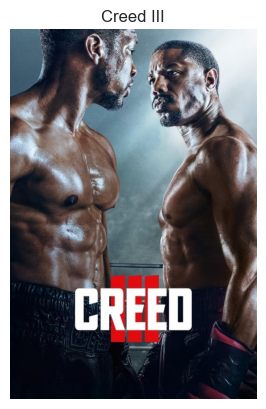

Recommendations



C:\Users\apoor\AppData\Local\Temp\ipykernel_28292\1736655358.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


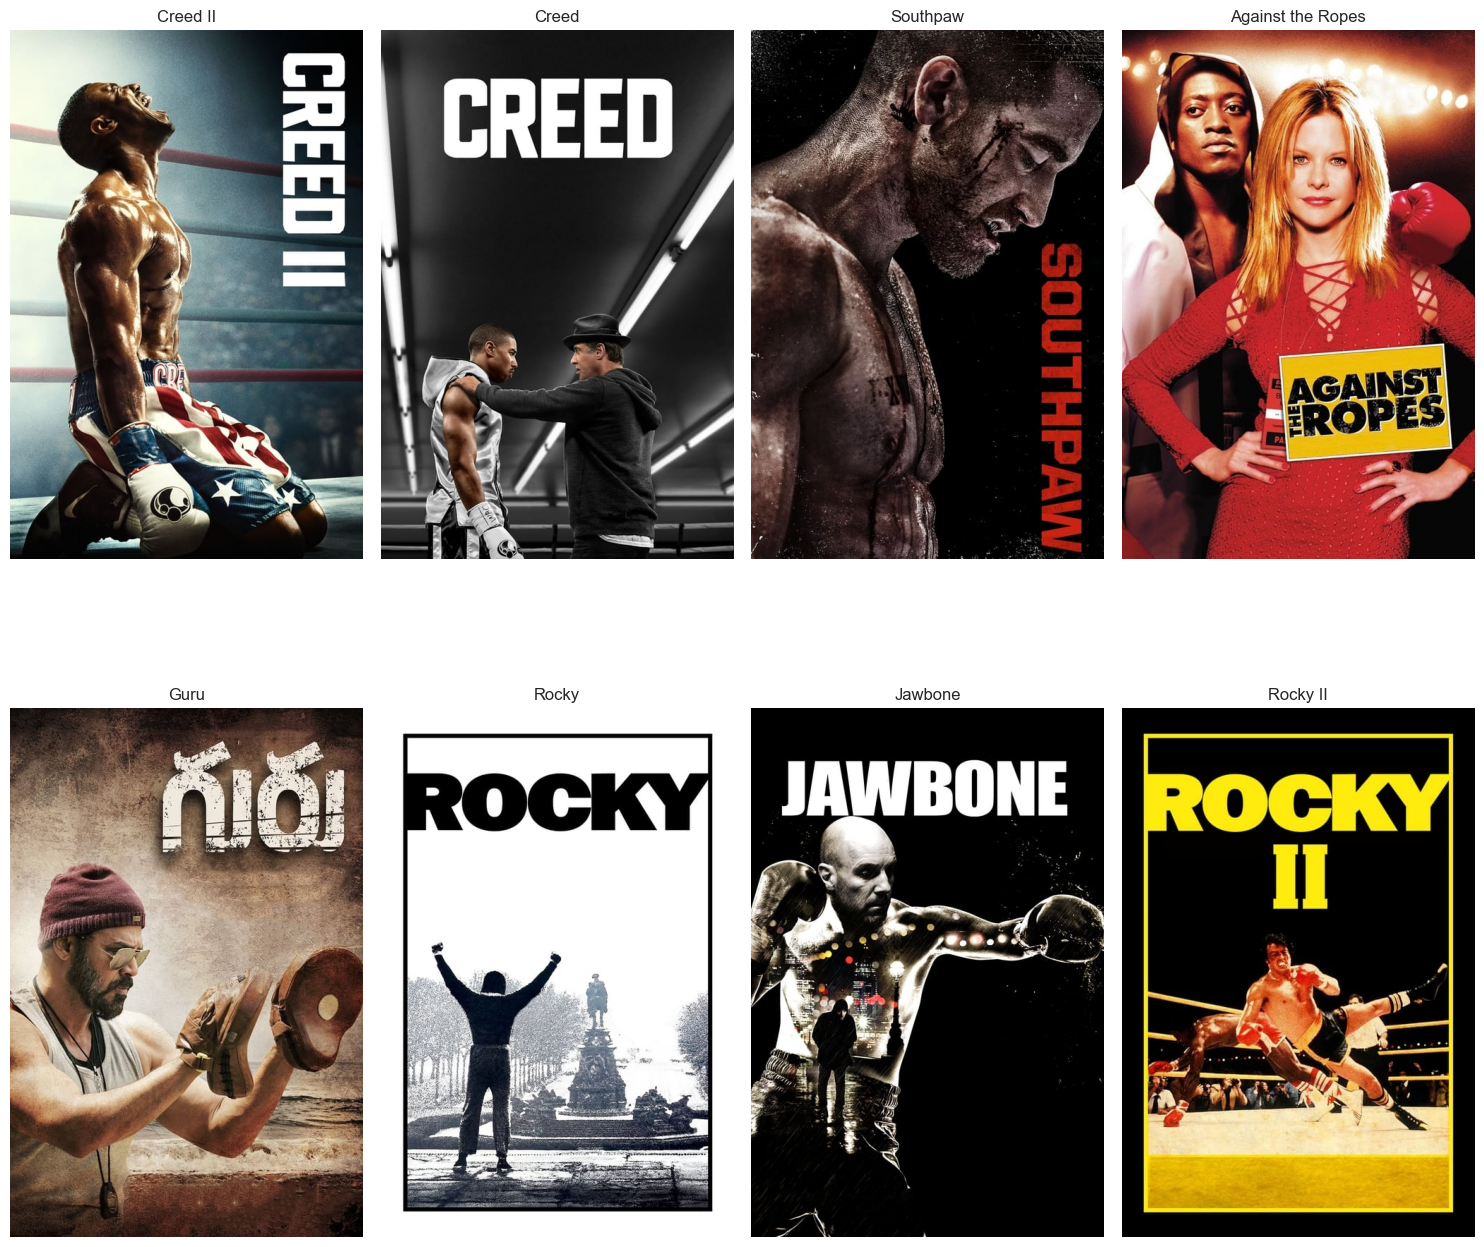

In [22]:
get_recommendations("Creed III")

In [25]:
pickle.dump(movies_df,open('../pkl/movie_list.pkl','wb'))
pickle.dump(tfidf_matrix,open('../pkl/tfidf_matrix.pkl','wb'))

Using CountVectorizer for the second model

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
# Define a Vectorizer Object. 
vectorizer = CountVectorizer()

In [31]:
# Fit and transform the text data
X = vectorizer.fit_transform(movies_df['tags'])

In [33]:
def get_recommendations(title):
    # Get the index of the movie that matches the title
    idx = movies_df.index[movies_df['title'] == title][0]
    # show given movie poster
    try:
        a = io.imread(f'https://image.tmdb.org/t/p/w500/{movies_df.loc[idx, "poster_path"]}')
        plt.imshow(a)
        plt.axis('off')
        plt.title(title)
        plt.show()
    except:pass
    
    print('Recommendations\n')

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(
        cosine_similarity(
            X,
            X[idx])))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:10]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    result = movies_df.iloc[movie_indices]
    
    # show reco. movie posters
    fig, ax = plt.subplots(2, 4, figsize=(15,15))
    ax=ax.flatten()
    for i, j in enumerate(result.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(result.iloc[i].title)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except: pass
    fig.tight_layout()
    fig.show()

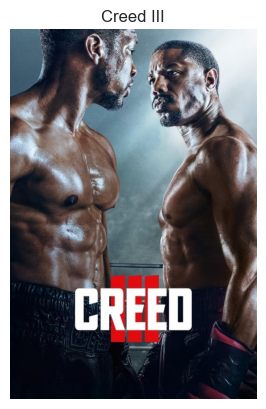

Recommendations



C:\Users\apoor\AppData\Local\Temp\ipykernel_14104\4087027872.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


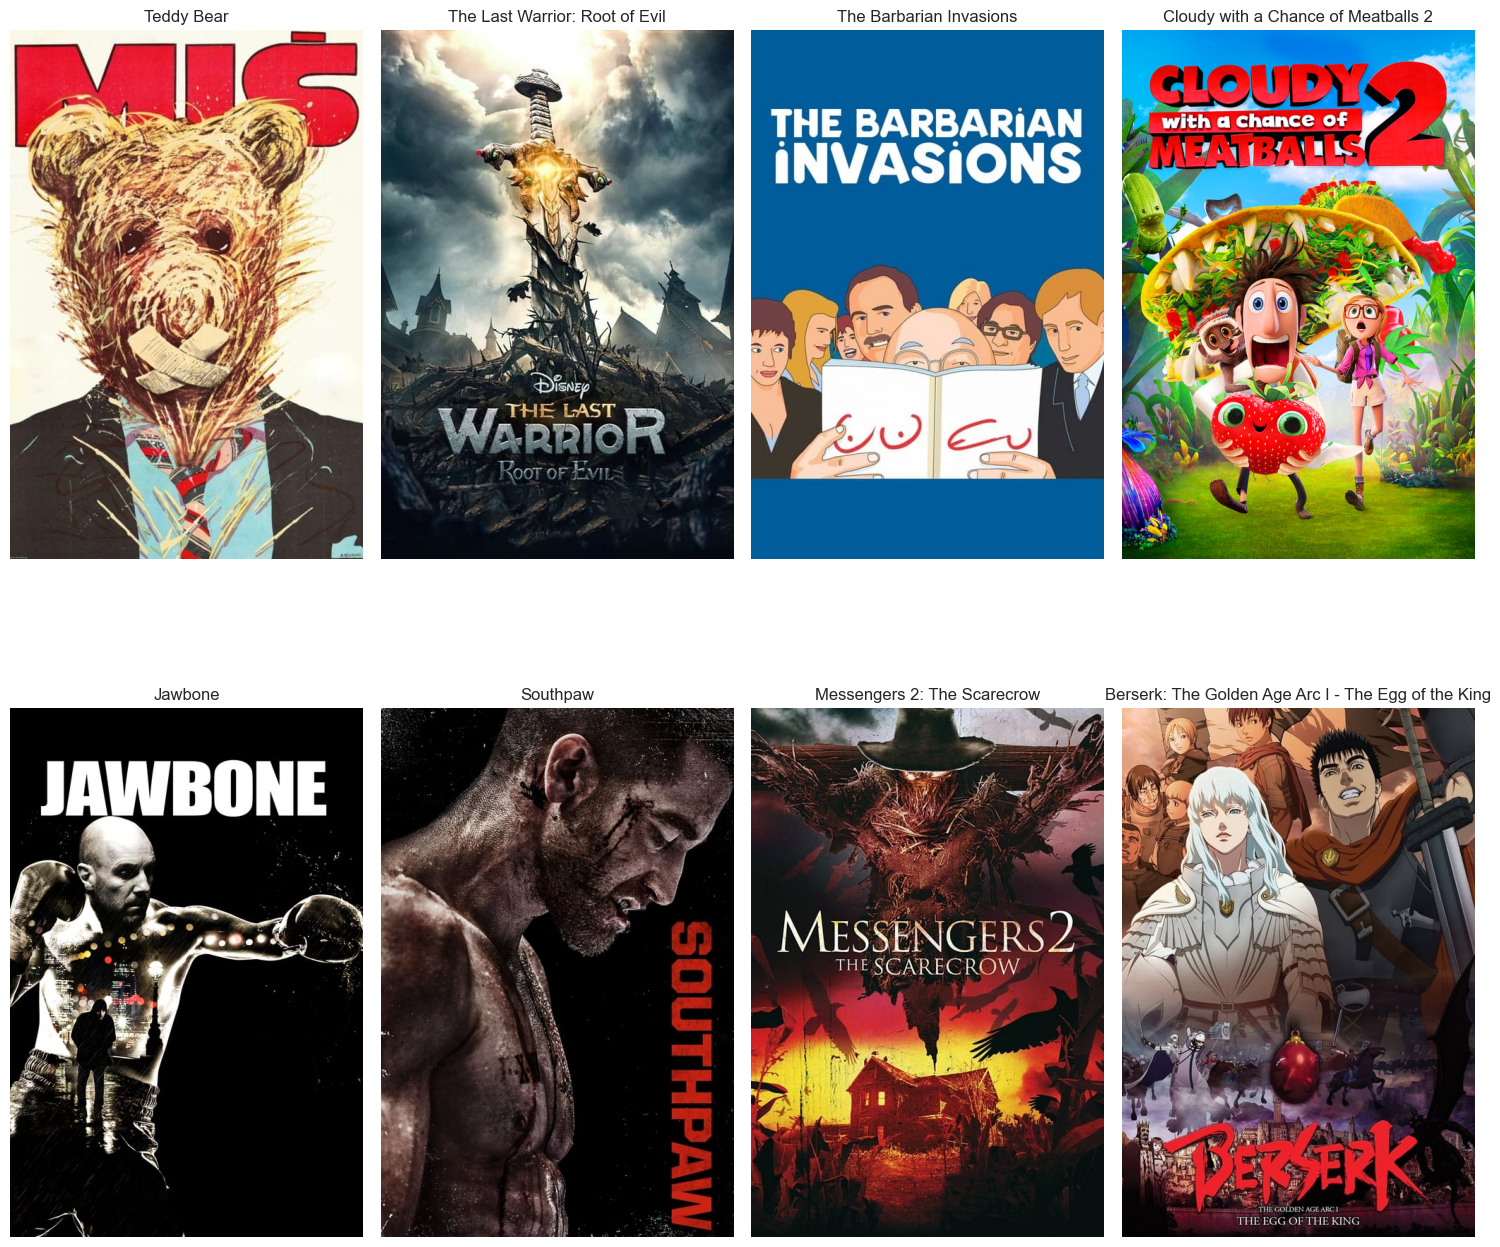

In [34]:
get_recommendations("Creed III")